In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import keras
from keras.utils import register_keras_serializable
import math
from scipy.signal import windows
import cv2

from generators import SyntheticSpectrogramGenerator
from synthetic_spectrograms import *

## Load data

In [3]:
# Parameters
fs = 5000
duration = 3.0
windowLengthSec = 0.04
windowLengthSeg = int(windowLengthSec * fs)
windowLengthSegRounded = 2 ** math.ceil(math.log2(windowLengthSeg))
window = windows.hann(windowLengthSegRounded)
noverlap = int(0.75 * windowLengthSegRounded)
nfft = 1024

# Create data generator
batch_size = 16
num_train_batches = 2000
num_val_batches = 100
train_gen = SyntheticSpectrogramGenerator(batch_size, num_train_batches, fs, duration, window, noverlap, nfft)
val_gen = SyntheticSpectrogramGenerator(batch_size, num_val_batches, fs, duration, window, noverlap, nfft)

## Initialise model

In [4]:
@register_keras_serializable()
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [5]:
# Load the pre-trained model
model = keras.saving.load_model(
    'drive/MyDrive/saved_models/model_epoch_20.keras',
    custom_objects={"psnr": psnr}
)

# Freeze earlier layers for fine-tuning
for layer in model.layers[:len(model.layers) // 2]:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[psnr]
)

## Train model

In [6]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="drive/MyDrive/saved_models/finetune_{epoch:02d}.keras",
    monitor='val_psnr',
    mode='max',
    save_best_only=True
)

In [7]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    batch_size=4,
    steps_per_epoch=100,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 336ms/step - loss: 7.4127e-04 - psnr: 32.2189 - val_loss: 6.3472e-04 - val_psnr: 33.1193
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 322ms/step - loss: 6.4441e-04 - psnr: 32.7620 - val_loss: 5.8632e-04 - val_psnr: 33.1364
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - loss: 5.9505e-04 - psnr: 33.0499 - val_loss: 6.0649e-04 - val_psnr: 32.8362
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - loss: 5.8028e-04 - psnr: 33.1778 - val_loss: 6.0435e-04 - val_psnr: 32.8783
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 300ms/step - loss: 5.9770e-04 - psnr: 33.0924 - val_loss: 5.7692e-04 - val_psnr: 33.1352
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 287ms/step - loss: 5.8647e-04 - psnr: 33.1906 - val_loss: 6.0064e-04 - val_psnr: 32.8977
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 260ms/step - loss: 5.6411e-04 - psnr: 33.4199 - val_loss: 5.9764e-04 - val_psnr: 33.4018
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - loss: 5.7209

In [8]:
model.save('drive/MyDrive/n2n_finetuned.keras')

## Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


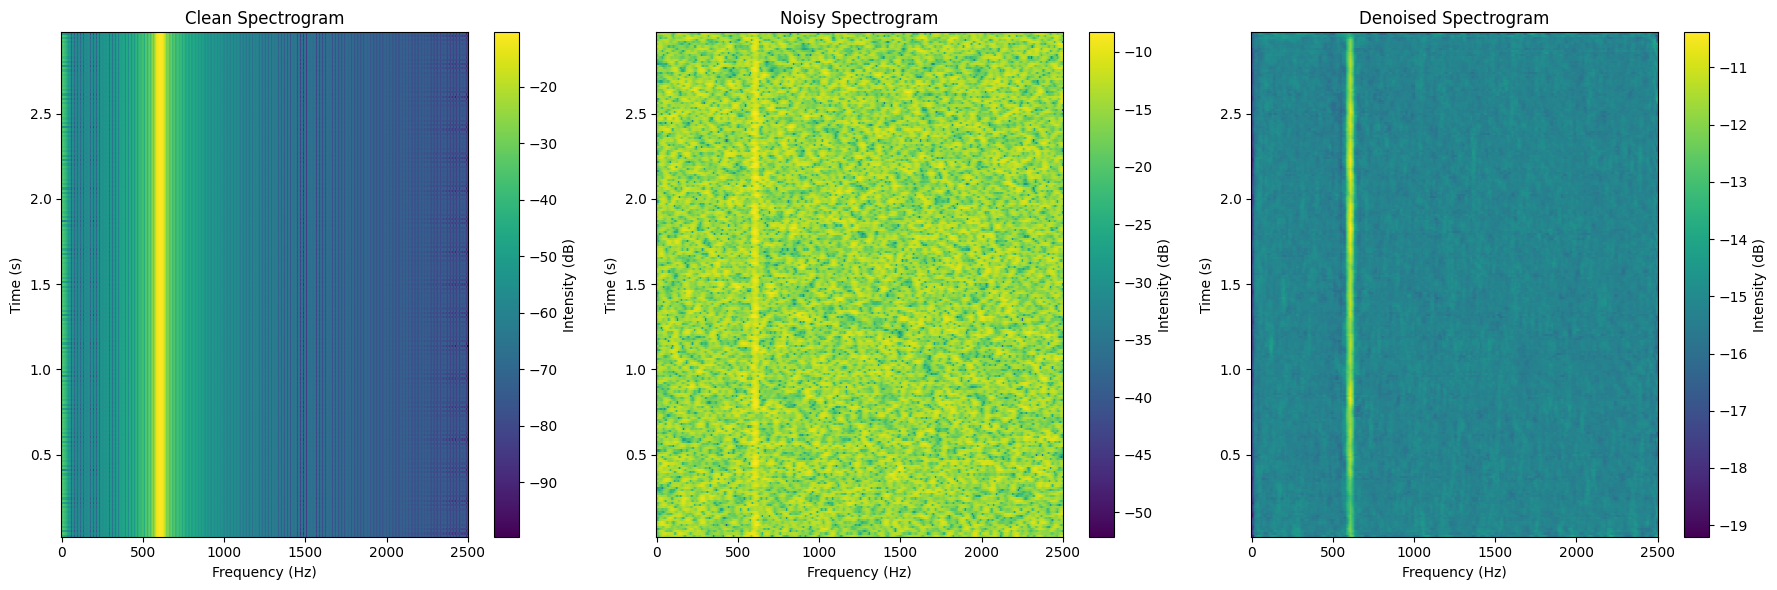

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot spectrograms
def plot_comparison(clean_spec, noisy_spec, denoised_spec, f, t):
    plt.figure(figsize=(18, 6))

    # Clean spectrogram
    plt.subplot(1, 3, 1)
    plt.pcolormesh(f, t, 10 * np.log10(clean_spec.T + 1e-10), shading='auto')
    plt.colorbar(label='Intensity (dB)')
    plt.title("Clean Spectrogram")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")

    # Noisy spectrogram
    plt.subplot(1, 3, 2)
    plt.pcolormesh(f, t, 10 * np.log10(noisy_spec.T + 1e-10), shading='auto')
    plt.colorbar(label='Intensity (dB)')
    plt.title("Noisy Spectrogram")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")

    # Denoised spectrogram
    plt.subplot(1, 3, 3)
    plt.pcolormesh(f, t, 10 * np.log10(denoised_spec.T + 1e-10), shading='auto')
    plt.colorbar(label='Intensity (dB)')
    plt.title("Denoised Spectrogram")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")

    plt.tight_layout()
    plt.show()

# Generate test data
_, clean_signal, _ = generate_sine_wave(duration, fs)
noisy_signal, _ = add_gaussian_noise(clean_signal)

# Create spectrograms
f, t, clean_spec = create_spectrogram(clean_signal, fs, window, noverlap, nfft)
_, _, noisy_spec = create_spectrogram(noisy_signal, fs, window, noverlap, nfft)

# Prepare noisy spectrogram for the model
noisy_spec_input = np.log1p(noisy_spec)
noisy_spec_input_resized = np.expand_dims(cv2.resize(noisy_spec_input, (256, 256)), axis=-1)
noisy_spec_input_rgb = np.repeat(noisy_spec_input_resized, 3, axis=-1)
noisy_spec_input_rgb = np.expand_dims(noisy_spec_input_rgb, axis=0)  # Add batch dimension

# Predict using the model
denoised_spec_pred = model.predict(noisy_spec_input_rgb)
denoised_spec_pred = np.squeeze(denoised_spec_pred)  # Remove batch dimension

# Resize the denoised spectrogram back to the original size
denoised_spec_resized = cv2.resize(denoised_spec_pred[:, :, 0], (noisy_spec.shape[1], noisy_spec.shape[0]))
denoised_spec = np.expm1(denoised_spec_resized)  # Reverse the log1p normalization

# Plot clean, noisy, and denoised spectrograms
plot_comparison(clean_spec, noisy_spec, denoised_spec, f, t)